In [1]:
from pangolin import normal_scale, bernoulli, binomial, add, exp, matmul, multi_normal_cov, VMapDist, Constant, RV, makerv, vmap, plate, Index, print_upstream, viz_upstream, loops, LogProb
import numpy as np

# How pangolin works

The purpose of this document is to explain how pangolin works "under the hood". This is more intended for people interested in extending pangolin or than for end users who just want to do some probabilistic inference and get some answers. (Though it might be useful for them, too.)

## CondDists

There are two main types in pangolin. The first is the conditional distribution or `CondDist`. Some `CondDist` objects are built in:

In [2]:
normal_scale

normal_scale

In [3]:
binomial

binomial

In [4]:
add

add

In [5]:
matmul

matmul

While all of these are formally considered "conditional distributions", only some of them are "random".

In [6]:
print(f"{normal_scale.random=}")
print(f"{binomial.random=}")
print(f"{add.random=}")
print(f"{matmul.random=}")

normal_scale.random=True
binomial.random=True
add.random=False
matmul.random=False


There are two points to emphasize about these. First, they are *conditional* distributions. `binomial` doesn't have, for example, a mean or variance because those depend on the parameters, which are not part of the `CondDist` object.

Second, for the most part `CondDist`s don't "do" anything. Their job is to *represent* stuff, no do stuff. So, for example, there is no method in pangolin like `normal_scale.log_prob` or `normal_scale.sample`.

The main exception to this is that a conditional distribution need to be able to compute the shape of the output from the shapes for the parents. (This is done so that shape checks can be done when connecting `CondDist`s together via `RV`s; more on that later.)

In [7]:
binomial.get_shape((),())

()

This result means that if both of the parameters of a binomial distribution are scalars (with shape `()`) then the output of the distribution will also be a scalar.

If you try to call this function with vector shapes, it will complain:

In [8]:
try:
    binomial.get_shape((3,),(3,)) # bad call, error expected
except Exception as e:
        print("Got exception:", e)

Got exception: all parents must have shape ()


This doesn't work because Pangolin does not believe in "broadcasting" over dimensions when calling distributions. While broadcasting is very convenient in simple situations, it quickly becomes very confusing, and is a common source of bugs. In Pangolin, a binomial distribution has two scalar parameters, end of story. (If you want vectorized distributions, use `vmap`; more on that later.)

The reason that there's a *function* `get_shape` as opposed to a field `shape` is that for some distributions, the shape of the outputs depends on the shapes of the inputs.

In [9]:
print(f"{multi_normal_cov.get_shape((2,),(2,2))=}")
print(f"{multi_normal_cov.get_shape((3,),(3,3))=}")

multi_normal_cov.get_shape((2,),(2,2))=(2,)
multi_normal_cov.get_shape((3,),(3,3))=(3,)


Again, these distributions check that the input dimensions make sense, and will complain if they don't.

In [10]:
try:
    multi_normal_cov.get_shape((3,),(2,2)) # bad call, error expected
except Exception as e:
    print("Got exception:", e)

Got exception: second parameter must be matrix with size matching first parameter


There are also `CondDist` *classes*, where the user will create particular `CondDist` instances themselves. The simplest of these is the `Constant` class.

In [11]:
dist = Constant(1)
print(f"{dist=}")
print(f"{dist.get_shape()=}")

dist=Constant(1)
dist.get_shape()=()


In [12]:
dist = Constant([1.1,2.2,3.3])
print(f"{dist=}")
print(f"{dist.get_shape()=}")

dist=Constant([1.1,2.2,3.3])
dist.get_shape()=(3,)


In [13]:
dist = Constant(np.random.randn(2,3))
print(f"{dist=}")
print(f"{dist.get_shape()=}")

dist=Constant([[0.17804166,0.14070548,-0.75724182],[0.63171971,0.04447245,0.11479228]])
dist.get_shape()=(2, 3)


Another of these is the `Index` class, used to select components from some higher-dimensional distribution.

# RVs

The second main type in pangolin is the random variable or `RV`. A random variable just has two fields:

1. A `CondDist`—the conditional distribution defining that random variable.
2. A tuple of parents, each of which are also `RV`s.

Here's a simple example

In [14]:
x = RV(Constant(1))
print(f"{x=}")

x=RV(Constant(1))


Here's another example:

In [15]:
loc = RV(Constant(0.0))
scale = RV(Constant(1.0))
x = RV(normal_scale,loc,scale)
print(f"{x=}")

x=RV(normal_scale, parents=[RV(Constant(0.)),RV(Constant(1.))])


**Always be careful to distinguish `RV`s from `CondDist`s.** It's easy to confuse `RV(Constant(1))` with `Constant(1)`, but these are not the same thing.

In Pangolin, there is no special "model" class. You just create collections of RVs that represent probability distributions and then you work with them directly.

# How users are actually expected to create RVs

Pangolin has a bunch of convenience features that make it easier to create `RV`s. One of these is that if `dist` is some `CondDist`, then `dist(a,b,c)` is equivalent to `RV(dist,a,b,c)`. This makes creating distributions easier.

In [16]:
x = RV(normal_scale, RV(Constant(0.0)), RV(Constant(1.0)))
print(f"{x=}")
y = normal_scale(RV(Constant(0.0)), RV(Constant(1.0)))
print(f"{y=}")

x=RV(normal_scale, parents=[RV(Constant(0.)),RV(Constant(1.))])
y=RV(normal_scale, parents=[RV(Constant(0.)),RV(Constant(1.))])


Another is the function `makerv`. All this does is check if the input is a `RV`. If it is, then it returns the input unchanged. If it is not, then it tries to cast the input into a RV with a Constant CondDist.

In [17]:
x = RV(bernoulli, RV(Constant(0.5)))
print(f"{x=}")
print(f"{makerv(x)=}")
print(f"{makerv(1)=}")

x=RV(bernoulli, parents=[RV(Constant(0.5))])
makerv(x)=RV(bernoulli, parents=[RV(Constant(0.5))])
makerv(1)=RV(Constant(1))


The second major convenience feature is that when a `CondDist` is called on some inputs, `makerv` is called on each of those inputs first. So, actually, `dist(a,b,c)` is equivalent to `dist(makerv(a),makerv(b),makerv(c))`. This allows you to create `RV`s with a much more natural syntax:

In [18]:
# doing things the hard way
loc = RV(Constant(0))
scale = RV(Constant(1))
x = RV(normal_scale,loc,scale)

# doing things the easy way, 100% equivalent
y = normal_scale(0, 1)

print(f"{x=}")
print(f"{y=}")

x=RV(normal_scale, parents=[RV(Constant(0)),RV(Constant(1))])
y=RV(normal_scale, parents=[RV(Constant(0)),RV(Constant(1))])


A user of Pangolin is expected to basically *always* create `RV`s by calling `CondDist`s (or sometimes other functions) on other `RV`s. But it's important to remember what's happening under the hood: Really, all these operations do is build a graph that represents some joint probability distribution.

# Printing

For examining models, pangolin provides `print_upstream` which prints the model in a sequential way.

In [19]:
z = normal_scale(0,1)
x = [normal_scale(z,1) for i in range(3)]
print_upstream(x)

shape | statement
----- | ---------
()    | a = 0
()    | b = 1
()    | c ~ normal_scale(a,b)
()    | d = 1
()    | e ~ normal_scale(c,d)
()    | f = 1
()    | g ~ normal_scale(c,f)
()    | h = 1
()    | i ~ normal_scale(c,h)


Note that this printing process doesn't use the python variable names for the different `RV`s. This is a deliberate choice—in Pangolin's internal representation, `RV`s do not *have* names. This doesn't pose much of a problem. Sometimes variables don't have names in Python, and sometimes they do. Either way, you can easily reference the RV by reference. So, in the above example, you can use `z` to refer to `z`. And you can use `x[2]` to refer to the last sampled variable.

Pangolin also provides `viz_upstream` which uses graphviz to lay out the model as a graph.

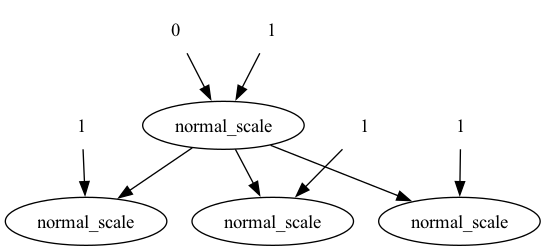

In [20]:
viz_upstream(x)

If you like, you can provide a list of observed variables to `viz_upstream` and these will be colored.

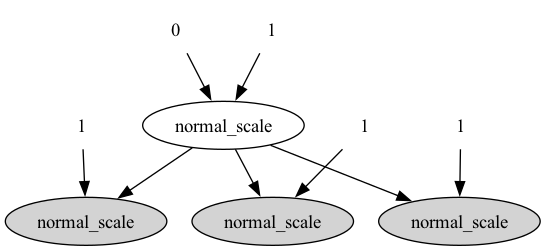

In [21]:
viz_upstream(x,x)

A user of Pangolin is expected to basically *always* create `RV`s by calling `CondDist`s (or sometimes other functions) on other `RV`s. But it's important to remember what's happening under the hood: Really, all these operations do is build a graph that represents some joint probability distribution.

# vmap

One special type of `CondDist` is the `VMapDist`. This takes one `CondDist` and makes a higher dimensional version of it. It takes three arguments:
* The base `CondDist`
* A tuple of which dimension of the input parameters to vectorize over (None if None)
* An axis_size (default of None)

The axis size is optional and will be inferred from the shapes of the input parameters unless no dimensions are vectorized. In that case it is required.

In [22]:
diag_normal = VMapDist(normal_scale, (0, 0))
print(f"{diag_normal.get_shape((3,),(3,))=}")

diag_normal.get_shape((3,),(3,))=(3,)


In [23]:
isotropic_normal = VMapDist(normal_scale, (0,None))
print(f"{isotropic_normal.get_shape((3,),())=}")

isotropic_normal.get_shape((3,),())=(3,)


In [24]:
iid_normal = VMapDist(normal_scale, (None,None), 3)
print(f"{iid_normal.get_shape((),())=}")

iid_normal.get_shape((),())=(3,)


In principle, you could just manually create `VMapDist`s like this and build arbitrary distributions this way. However, it would quickly becomes very tedious:

In [25]:
diag_normal = VMapDist(normal_scale,[0,0])
x = diag_normal([0,1],[2,3])
y = diag_normal([4,5],[6,7])
vec_exp = VMapDist(exp,(0,))
z = vec_exp(y)
u = diag_normal(x,z)

print_upstream(u)

shape | statement
----- | ---------
(2,)  | a = [0 1]
(2,)  | b = [2 3]
(2,)  | c ~ vmap(None, [0, 0], normal_scale)(a,b)
(2,)  | d = [4 5]
(2,)  | e = [6 7]
(2,)  | f ~ vmap(None, [0, 0], normal_scale)(d,e)
(2,)  | g = vmap(None, [0], exp)(f  )
(2,)  | h ~ vmap(None, [0, 0], normal_scale)(c,g)


Instead, the `vmap` function is provided that will do almost all of this work for you.

In [26]:
def scalar_dist(xi_mean,xi_scale,yi_mean,yi_scale):
    xi = normal_scale(xi_mean,xi_scale)
    yi = normal_scale(yi_mean,yi_scale)
    return normal_scale(xi,exp(yi))

x_mean = makerv([0,1])
x_scale = makerv([2,2])
y_mean = makerv([3,4])
y_scale = makerv([5,5])
u = vmap(scalar_dist)(x_mean,x_scale,y_mean,y_scale)

print_upstream(u)

shape | statement
----- | ---------
(2,)  | a = [0 1]
(2,)  | b = [2 2]
(2,)  | c ~ vmap(2, [0, 0], normal_scale)(a,b)
(2,)  | d = [3 4]
(2,)  | e = [5 5]
(2,)  | f ~ vmap(2, [0, 0], normal_scale)(d,e)
(2,)  | g = vmap(2, [0], exp)(f  )
(2,)  | h ~ vmap(2, [0, 0], normal_scale)(c,g)


`vmap` follows the syntax of [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) exactly, except it does not (currently) support the `out_axes`, `axis_name`, or `spmd_axis_name` arguments.

We can use a second `in_axes` argument to only vectorize over some of the inputs.

In [27]:
def scalar_dist(xi_mean,xi_scale,yi_mean,yi_scale):
    xi = normal_scale(xi_mean,xi_scale)
    yi = normal_scale(yi_mean,yi_scale)
    return normal_scale(xi,exp(yi))

x_mean = makerv([0,1])
x_scale = makerv(2)
y_mean = makerv([3,4])
y_scale = makerv(5)
u = vmap(scalar_dist, (0,None,0,None))(x_mean,x_scale,y_mean,y_scale)

print_upstream(u)

shape | statement
----- | ---------
(2,)  | a = [0 1]
()    | b = 2
(2,)  | c ~ vmap(2, [0, ∅], normal_scale)(a,b)
(2,)  | d = [3 4]
()    | e = 5
(2,)  | f ~ vmap(2, [0, ∅], normal_scale)(d,e)
(2,)  | g = vmap(2, [0], exp)(f  )
(2,)  | h ~ vmap(2, [0, 0], normal_scale)(c,g)


Like `jax.vmap`, the arguments can be arbitrary pytrees, in which case the `in_axes` only needs to be a pytree which is a "tree prefix" to the arguments.

That sentence probably makes no sense if you aren't an experienced jax programmer, so here's a couple examples: If you like, you can put parameters inside of a dictionary.

In [28]:
def scalar_dist(xi_params, yi_mean, yi_scale):
    xi = normal_scale(xi_params['mean'],xi_params['scale'])
    yi = normal_scale(yi_mean,yi_scale)
    return normal_scale(xi,exp(yi))

x_params = {'mean': makerv([0,1]), 'scale': makerv([2,2])}
y_mean = makerv([3,4])
y_scale = makerv([5,5])
u = vmap(scalar_dist)(x_params,y_mean,y_scale)

print_upstream(u)

shape | statement
----- | ---------
(2,)  | a = [0 1]
(2,)  | b = [2 2]
(2,)  | c ~ vmap(2, [0, 0], normal_scale)(a,b)
(2,)  | d = [3 4]
(2,)  | e = [5 5]
(2,)  | f ~ vmap(2, [0, 0], normal_scale)(d,e)
(2,)  | g = vmap(2, [0], exp)(f  )
(2,)  | h ~ vmap(2, [0, 0], normal_scale)(c,g)


And you can control vectorization *inside the dictionary*.

In [29]:
def scalar_dist(xi_params, yi_mean, yi_scale):
    xi = normal_scale(xi_params['mean'],xi_params['scale'])
    yi = normal_scale(yi_mean,yi_scale)
    return normal_scale(xi,exp(yi))

x_params = {'mean': makerv([0,1]), 'scale': makerv(2)}
y_mean = makerv([3,4])
y_scale = makerv(5)
in_axes = ({'mean':0,'scale':None}, 0, None)
u = vmap(scalar_dist,in_axes)(x_params,y_mean,y_scale)

print_upstream(u)

shape | statement
----- | ---------
(2,)  | a = [0 1]
()    | b = 2
(2,)  | c ~ vmap(2, [0, ∅], normal_scale)(a,b)
(2,)  | d = [3 4]
()    | e = 5
(2,)  | f ~ vmap(2, [0, ∅], normal_scale)(d,e)
(2,)  | g = vmap(2, [0], exp)(f  )
(2,)  | h ~ vmap(2, [0, 0], normal_scale)(c,g)


**VERY IMPORTANT GOTCHA**. In most cases in Pangolin you can send constants like `2` or lists like `[1,2,3]` into `CondDist`s and they will automatically get converted into Constant RVs. This does not work with vmap. The reason is that for vmap allows arguments that are arbitrary pytrees of RVs. So it has no way of knowing if `[1,2,3]` should be converted to `RV(Constant([1,2,3]))` or `[RV(Constant(1)), RV(Constant(2)), RV(Constant(3))]`.

To be safe, *always explicitly convert any constants into RVs (via `makerv`) before calling vmap*. You'll often get away with not doing this, but it can cause hard-to diagnose or understand bugs.

Pangolin also provides `plate`. This is just another syntax that accomplishes the same thing as `vmap`. It can be more natural in some cases, especially when you make clever use of the walrus operator like you see here.

In [30]:
z, x = plate(N=3)(lambda:
    (zi:=normal_scale(0,1),
     xi:=normal_scale(zi,1)))

print_upstream(x)

shape | statement
----- | ---------
()    | a = 0
()    | b = 1
(3,)  | c ~ vmap(3, [∅, ∅], normal_scale)(a,b)
()    | d = 1
(3,)  | e ~ vmap(3, [0, ∅], normal_scale)(c,d)


In [31]:
z, (x,y) = plate(N=3)(lambda:
    (zi := normal_scale(0,1),
     plate(N=4)(lambda:
            (xij := normal_scale(zi,1),
             yij := normal_scale(xij,1)))))

print_upstream(y)

shape  | statement
------ | ---------
()     | a = 0
()     | b = 1
(3,)   | c ~ vmap(3, [∅, ∅], normal_scale)(a,b)
()     | d = 1
(3, 4) | e ~ vmap(3, [0, ∅], vmap(4, [∅, ∅], normal_scale))(c,d)
()     | f = 1
(3, 4) | g ~ vmap(3, [0, ∅], vmap(4, [0, ∅], normal_scale))(e,f)


Pangolin also provides an **EXTREMELY EXPERIMENTAL** (even more than for Pangolin itself) interface for "pseudo-loops". As you can probably guess from the output below, no actual loop is executed at all. This is just a special syntax that allows you to create VMapDists.

In [32]:
z = loops.VMapRV()
x = loops.VMapRV()
with loops.Loop(3) as i:
    z[i] = normal_scale(0,1)
    with loops.Loop(5) as j:
        x[i,j] = normal_scale(z[i],1)
print_upstream(x)

shape  | statement
------ | ---------
()     | a = 0
()     | b = 1
(3,)   | c ~ vmap(3, [∅, ∅], normal_scale)(a,b)
()     | d = 1
(3, 5) | e ~ vmap(3, [0, ∅], vmap(5, [∅, ∅], normal_scale))(c,d)


# Indexing

In Pangolin, an `Index` is a special type of non-random `CondDist`.

In [33]:
z = makerv([[1,2],[3,4],[5,6]])
x = z[:,[0,2]]

print_upstream(x)

shape  | statement
------ | ---------
(3, 2) | a = [[1 2] [3 4] [5 6]]
(2,)   | b = [0 2]
(3, 2) | c = index(:,∅)(a,b)


What's happening here? Well, we could write the same thing more explicitly like this:

In [34]:
z = makerv([[1,2],[3,4],[5,6]])
index_cond_dist = Index(slice(None),None)
idx = makerv([0,2])
x = RV(index_cond_dist,z,idx)

print_upstream(x)

shape  | statement
------ | ---------
(3, 2) | a = [[1 2] [3 4] [5 6]]
(2,)   | b = [0 2]
(3, 2) | c = index(:,∅)(a,b)


An `Index` object is initialized with a set of arguments, each of which should be either `None` or a `slice` with fixed integer arguments. (No RVs inside of the slices are allowed). Then, when you create an `RV` using an `Index`, the first parent is the `RV` being indexed, and the other parent are the indices for all the *non*-sliced dimensions.

In Pangolin you *are* allowed to use RVs for the non-sliced dimensions. But different inference backends may not be able to do inference on them, simply because many inference backends can't handle (non-observed) integer RVs at all. Currently, the JAGS backend can handle integer-valued RVs, Stan and Numpyro cannot.

# LogProb

LogProb is also **HIGHLY EXPERIMENTAL**. It converts a random CondDist into a non-random one that computes conditional log-probabilities.

In [35]:
normal_log_prob = LogProb(normal_scale)
normal_log_prob

LogProb(normal_scale)

Note: This is still a CondDist, not a RV. So to actually create a model you could do something like this:

In [36]:
x = normal_scale(0,1)
l = LogProb(normal_scale)(x,0,1)
print_upstream(l)

shape | statement
----- | ---------
()    | a = 0
()    | b = 1
()    | c ~ normal_scale(a,b  )
()    | d = 0
()    | e = 1
()    | f = LogProb(normal_scale)(c,d,e)


In this model, `l` has the distribution of the log-probability density of the standard Normal distribution.